# 7. KMeans Clustering with Scikit-Learn and MLlib

Implement the K-Means Algorithm using different tools!

In [32]:
%matplotlib inline
from sklearn import datasets
import pandas as pd
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans
from sklearn import datasets

The dataset class provides access to different public datasets. It will return a scikit-learn bunch: <http://scikit-learn.org/stable/datasets/index.html>

In [2]:
iris = datasets.load_iris()

Convert Scikit Bunch to Pandas Dataframe

In [39]:
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_df['target'] = iris.target
iris_df["target_name"]=iris['target_names'][df['target']] 
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,target_name
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa


## 7.1 Cluster the data using the KMeans implementation of scikit-learn!

* Resource: <http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_iris.html>
* Measure the runtime for training the model!
* Experiment with different number of clusters! What are your observations!
* Plot the results!

CPU times: user 1.45 s, sys: 24.5 ms, total: 1.48 s
Wall time: 1.49 s


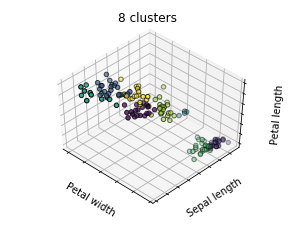

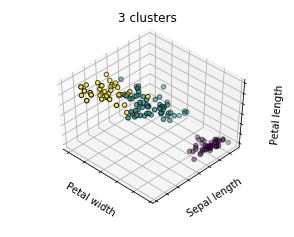

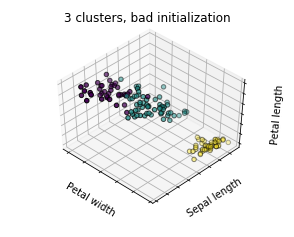

In [36]:
%%time

X = iris.data
y = iris.target

estimators = [('k_means_iris_8', KMeans(n_clusters=8)),
              ('k_means_iris_3', KMeans(n_clusters=3)),
              ('k_means_iris_bad_init', KMeans(n_clusters=3, n_init=1,
                                               init='random'))]

fignum = 1
titles = ['8 clusters', '3 clusters', '3 clusters, bad initialization']
for name, est in estimators:
    fig = plt.figure(fignum, figsize=(4, 3))
    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
    est.fit(X)
    labels = est.labels_

    ax.scatter(X[:, 3], X[:, 0], X[:, 2],
               c=labels.astype(np.float), edgecolor='k')

    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])
    ax.set_xlabel('Petal width')
    ax.set_ylabel('Sepal length')
    ax.set_zlabel('Petal length')
    ax.set_title(titles[fignum - 1])
    ax.dist = 12
    fignum = fignum + 1

Plot Ground Truth

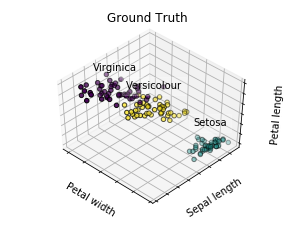

In [35]:
# Plot the ground truth
fig = plt.figure(fignum, figsize=(4, 3))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

for name, label in [('Setosa', 0),
                    ('Versicolour', 1),
                    ('Virginica', 2)]:
    ax.text3D(X[y == label, 3].mean(),
              X[y == label, 0].mean(),
              X[y == label, 2].mean() + 2, name,
              horizontalalignment='center',
              bbox=dict(alpha=.2, edgecolor='w', facecolor='w'))

# Reorder the labels to have colors matching the cluster results
y = np.choose(y, [1, 2, 0]).astype(np.float)
ax.scatter(X[:, 3], X[:, 0], X[:, 2], c=y, edgecolor='k')
ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Petal width')
ax.set_ylabel('Sepal length')
ax.set_zlabel('Petal length')
ax.set_title('Ground Truth')
ax.dist = 12
fig.show()

## 7.2 MLlib Clustering

* MLLib KMeans Example: 
    * <https://spark.apache.org/docs/latest/ml-clustering.html>
    * <https://spark.apache.org/docs/latest/api/python/>
    * <https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.evaluation.ClusteringEvaluator>
* Run KMeans on the provided Iris dataset!
* Validate the quality of the model using the sum of the squared error for each point! Use the ClusterEvaluator of Spark MLlib!

In [38]:
# Initialize PySpark
SPARK_MASTER="local[1]"
#SPARK_MASTER="spark://mpp3r03c04s06.cos.lrz.de:7077"
APP_NAME = "PySpark Lecture"

# If there is no SparkSession, create the environment
try:
    sc and spark
except NameError as e:
  #import findspark
  #findspark.init()
    import pyspark
    import pyspark.sql
    conf=pyspark.SparkConf().set("spark.cores.max", "4")
    sc = pyspark.SparkContext(master=SPARK_MASTER, conf=conf)
    spark = pyspark.sql.SparkSession(sc).builder.appName(APP_NAME).getOrCreate()

print("PySpark initiated...")

PySpark initiated...


In [52]:
iris_sdf=spark.createDataFrame(iris_df)
iris_sdf=iris_sdf.withColumnRenamed("target" , "target_original")
iris_sdf=iris_sdf.withColumnRenamed("target_name" , "target_name_original")

In [54]:
iris_sdf.show(5)

+-----------------+----------------+-----------------+----------------+---------------+--------------------+
|sepal length (cm)|sepal width (cm)|petal length (cm)|petal width (cm)|target_original|target_name_original|
+-----------------+----------------+-----------------+----------------+---------------+--------------------+
|              5.1|             3.5|              1.4|             0.2|              0|              setosa|
|              4.9|             3.0|              1.4|             0.2|              0|              setosa|
|              4.7|             3.2|              1.3|             0.2|              0|              setosa|
|              4.6|             3.1|              1.5|             0.2|              0|              setosa|
|              5.0|             3.6|              1.4|             0.2|              0|              setosa|
+-----------------+----------------+-----------------+----------------+---------------+--------------------+
only showing top 5 

In [68]:
%%time 
from pyspark.ml.feature import FeatureHasher
import pyspark.ml.clustering 
from pyspark.ml.evaluation import ClusteringEvaluator

hasher = FeatureHasher(inputCols=["sepal length (cm)", "sepal width (cm)", "petal length (cm)", 
                                  "petal width (cm)"],
                       outputCol="features")

featurized = hasher.transform(iris_sdf)

kmeans = pyspark.ml.clustering.KMeans(predictionCol='target').setK(3).setSeed(1)
model = kmeans.fit(featurized)
predictions = model.transform(featurized)

CPU times: user 99.3 ms, sys: 21.2 ms, total: 121 ms
Wall time: 5.32 s


In [69]:
predictions.show(3)

+-----------------+----------------+-----------------+----------------+---------------+--------------------+--------------------+------+
|sepal length (cm)|sepal width (cm)|petal length (cm)|petal width (cm)|target_original|target_name_original|            features|target|
+-----------------+----------------+-----------------+----------------+---------------+--------------------+--------------------+------+
|              5.1|             3.5|              1.4|             0.2|              0|              setosa|(262144,[38927,59...|     2|
|              4.9|             3.0|              1.4|             0.2|              0|              setosa|(262144,[38927,59...|     2|
|              4.7|             3.2|              1.3|             0.2|              0|              setosa|(262144,[38927,59...|     2|
+-----------------+----------------+-----------------+----------------+---------------+--------------------+--------------------+------+
only showing top 3 rows



Model Evaluation

* https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.evaluation.ClusteringEvaluator

* Evaluator for Clustering results, which expects two input columns: prediction and features. The metric computes the Silhouette measure using the squared Euclidean distance.

In [63]:
from pyspark.ml.evaluation import ClusteringEvaluator
evaluator = ClusteringEvaluator(predictionCol='target')
silhouette = evaluator.evaluate(predictions)

In [65]:
silhouette

0.7342113066202722